<a href="https://colab.research.google.com/github/Tushar-Pingle/Codes-/blob/main/Google_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import yfinance as yf
import datetime

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [3]:
end_date = datetime.datetime(2023, 7, 23)
start_date = datetime.datetime(2018, 7, 23)

# Replace the ticker symbol with 'GOOGL' for Google stock data
df = yf.download('GOOGL', start=start_date, end=end_date)
print(df.head())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-07-23  59.783001  60.755001  59.600498  60.549999  60.549999   65446000
2018-07-24  63.549999  63.750000  62.207001  62.907501  62.907501  107600000
2018-07-25  62.631001  63.911999  62.452499  63.797001  63.797001   51104000
2018-07-26  63.359001  64.370003  63.150002  64.275002  64.275002   54686000
2018-07-27  64.456001  64.571999  62.224499  62.644501  62.644501   48362000


In [4]:
indicepanel = pd.DataFrame(index=df.index)

indicepanel['google'] = df['Open'].shift(-1) - df['Open']
indicepanel['google_lag1'] = indicepanel['google'].shift(1)
indicepanel['Price'] = df['Open']
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

print(indicepanel.isnull().sum())

google         0
google_lag1    0
Price          0
dtype: int64


In [5]:
train = indicepanel.iloc[-1258:-629, :]
test = indicepanel.iloc[-629:, :]

print(train.shape, test.shape)


(628, 3) (629, 3)


In [6]:
# Find the indice with the largest correlation
corr_array = train[['google', 'google_lag1']].corr()['google']
print(corr_array)

# Define the formula with 'google_lag1' as the predictor for 'google'
formula = 'google ~ google_lag1'

# Fit the model using 'google_lag1' as the predictor for 'google'
lm = smf.ols(formula=formula, data=train).fit()

# Print the summary of the model
print(lm.summary())

google         1.000000
google_lag1   -0.122685
Name: google, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                 google   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     9.566
Date:                Sun, 23 Jul 2023   Prob (F-statistic):            0.00207
Time:                        19:30:54   Log-Likelihood:                -1037.0
No. Observations:                 628   AIC:                             2078.
Df Residuals:                     626   BIC:                             2087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [7]:
# Get the predictions for 'google' by making copies of the DataFrames
train_copy = train.copy()
test_copy = test.copy()

train_copy['PredictedY'] = lm.predict(train_copy)
test_copy['PredictedY'] = lm.predict(test_copy)

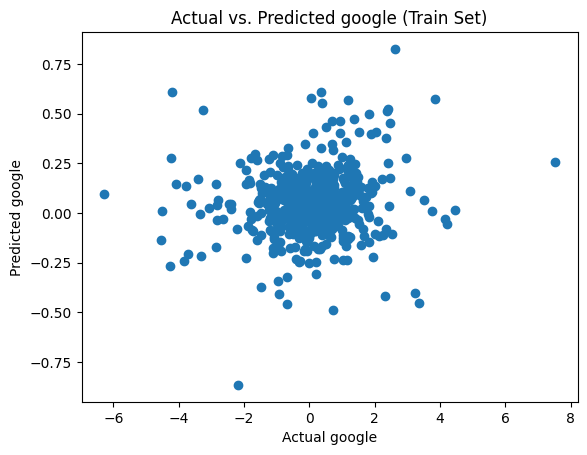

In [8]:
# Plot the scatter plot between the actual 'google' and predicted 'google' for Train Set
plt.scatter(train['google'], train_copy['PredictedY'])
plt.xlabel('Actual google')
plt.ylabel('Predicted google')
plt.title('Actual vs. Predicted google (Train Set)')
plt.show()

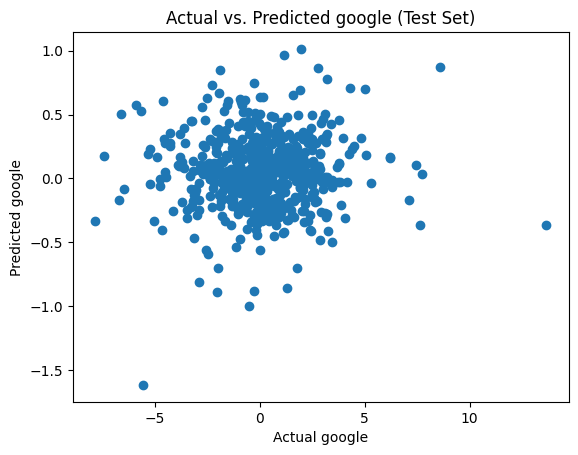

In [9]:
# Plot the scatter plot between the actual 'google' and predicted 'google' for Test Set
plt.scatter(test['google'], test_copy['PredictedY'])
plt.xlabel('Actual google')
plt.ylabel('Predicted google')
plt.title('Actual vs. Predicted google (Test Set)')
plt.show()


In [16]:
def adjustedMetric(data, model, model_k, yname):
    data['PredictedY'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean()) ** 2).sum()
    SSR = ((data['PredictedY'] - data[yname].mean()) ** 2).sum()
    SSE = ((data[yname] - data['PredictedY']) ** 2).sum()
    r2 = SSR / SST
    adjustR2 = 1 - (1 - r2) * (data.shape[0] - 1) / (data.shape[0] - model_k - 1)
    RMSE = (SSE / (data.shape[0] - model_k - 1)) ** 0.5
    return adjustR2, RMSE

def assessTable(test, train, model, model_k, yname):
    # Create copies of DataFrames to avoid the SettingWithCopyWarning
    train = train.copy()
    test = test.copy()

    # Calculate 'PredictedY' using .loc to avoid the warning
    train['PredictedY'] = model.predict(train)
    test['PredictedY'] = model.predict(test)

    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

# Get the assessment table for the linear regression model using 'google_lag1' as predictor for 'google'
assessment_table = assessTable(test, train, lm, 1, 'google')

print(assessment_table)


         Train      Test
R2    0.013478  0.013507
RMSE  1.263642  2.271016


<ipython-input-18-e064db5571af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Order'] = np.where(train['PredictedY'] > 0, 1, -1)
<ipython-input-18-e064db5571af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Profit'] = train['google'] * train['Order']
<ipython-input-18-e064db5571af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

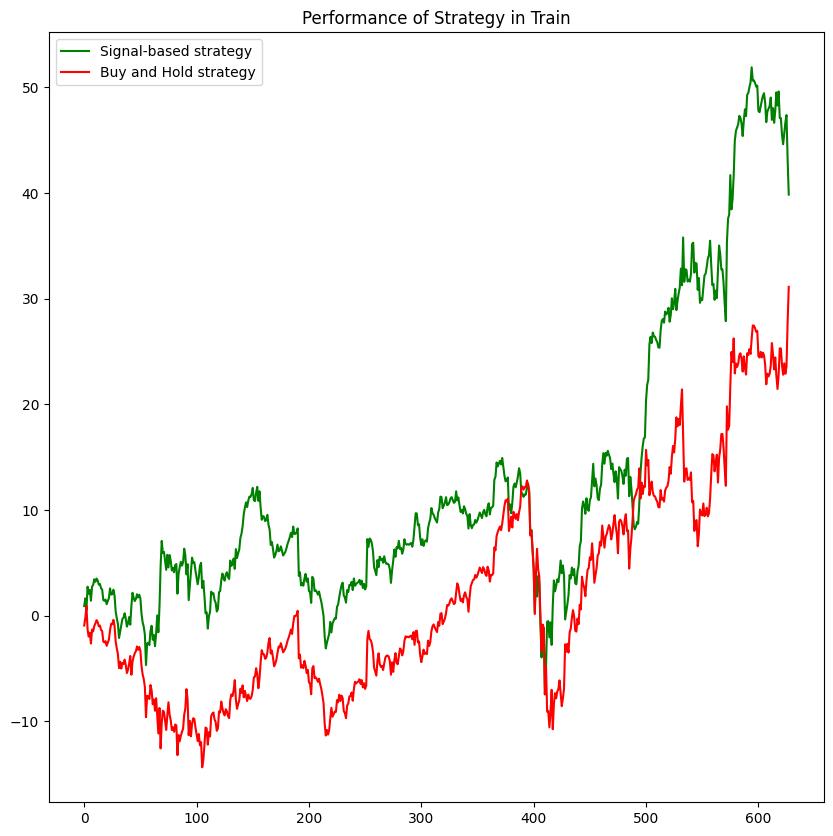

In [18]:
# Profit of Signal-based strategy for train
train['Order'] = np.where(train['PredictedY'] > 0, 1, -1)
train['Profit'] = train['google'] * train['Order']
train['Wealth'] = train['Profit'].cumsum()

plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(train['Wealth'].values, color='green', label='Signal-based strategy')
plt.plot(train['google'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

<ipython-input-12-14ddc67e00b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Order'] = np.where(test['PredictedY'] > 0, 1, -1)
<ipython-input-12-14ddc67e00b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Profit'] = test['google'] * test['Order']
<ipython-input-12-14ddc67e00b6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

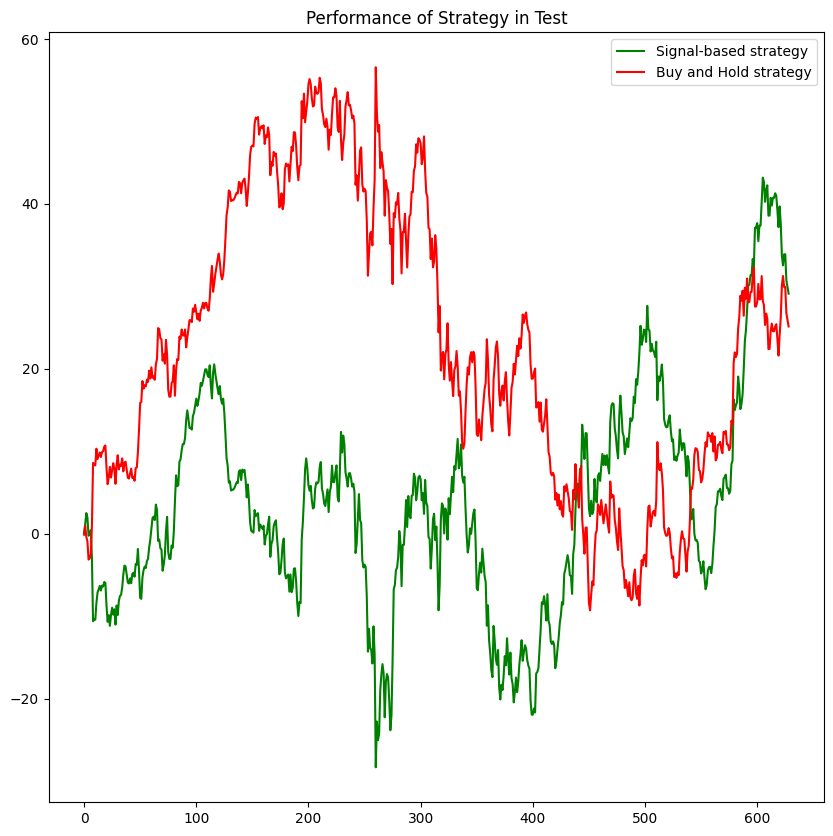

In [12]:
# Profit of Signal-based strategy for test
test['Order'] = np.where(test['PredictedY'] > 0, 1, -1)
test['Profit'] = test['google'] * test['Order']
test['Wealth'] = test['Profit'].cumsum()

plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Test')
plt.plot(test['Wealth'].values, color='green', label='Signal-based strategy')
plt.plot(test['google'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [30]:
# Evaluation of model - Practical Standard
train['Wealth'] = train['Wealth'] + train.loc[train.index[0], 'Price']
test['Wealth'] = test['Wealth'] + test.loc[test.index[0], 'Price']

# Sharpe Ratio on train data
train['Return'] = np.log(train['Wealth']) - np.log(train['Wealth'].shift(1))
dailyr_train = train['Return'].dropna()
print('===================================================================================''\n')
print('Daily Sharpe Ratio on Train data:', dailyr_train.mean() / dailyr_train.std(ddof=1))
print('Yearly Sharpe Ratio on Train data:', (252 ** 0.5) * dailyr_train.mean() / dailyr_train.std(ddof=1))

# Sharpe Ratio on test data
test['Return'] = np.log(test['Wealth']) - np.log(test['Wealth'].shift(1))
dailyr_test = test['Return'].dropna()

print('Daily Sharpe Ratio on Test data:', dailyr_test.mean() / dailyr_test.std(ddof=1))
print('Yearly Sharpe Ratio on Test data:', (252 ** 0.5) * dailyr_test.mean() / dailyr_test.std(ddof=1), '\n')
print('===================================================================================''\n')



Daily Sharpe Ratio on Train data: 0.048292549770671475
Yearly Sharpe Ratio on Train data: 0.7666204612224363
Daily Sharpe Ratio on Test data: 0.020052056181309057
Yearly Sharpe Ratio on Test data: 0.3183165235874356 




<ipython-input-30-1cf25a8da13b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Wealth'] = train['Wealth'] + train.loc[train.index[0], 'Price']
<ipython-input-30-1cf25a8da13b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Wealth'] = test['Wealth'] + test.loc[test.index[0], 'Price']
<ipython-input-30-1cf25a8da13b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [32]:
# Maximum Drawdown on train data
train['Peak'] = train['Wealth'].cummax()
train['Drawdown'] = (train['Peak'] - train['Wealth']) / train['Peak']

print('===================================================================================''\n')
print('Maximum Drawdown on Train data:', train['Drawdown'].max())

# Maximum Drawdown on test data
test['Peak'] = test['Wealth'].cummax()
test['Drawdown'] = (test['Peak'] - test['Wealth']) / test['Peak']
print('Maximum Drawdown on Test data:', test['Drawdown'].max(), '\n')
print('===================================================================================''\n')


Maximum Drawdown on Train data: 0.042757548340631085
Maximum Drawdown on Test data: 0.05599024166549395 




<ipython-input-32-15831c5bfeca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Peak'] = train['Wealth'].cummax()
<ipython-input-32-15831c5bfeca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Drawdown'] = (train['Peak'] - train['Wealth']) / train['Peak']
<ipython-input-32-15831c5bfeca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py